In [ ]:
!pip install transformers sentencepiece

In [ ]:
%matplotlib inline

import requests
from urllib.parse import urlencode
import os
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/4YD7r8k4ugFksg'

In [ ]:
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [ ]:
download_response = requests.get(download_url)
with open('downloaded_file.zip', 'wb') as f:
    f.write(download_response.content)

In [ ]:
!unzip -qo "downloaded_file.zip" -d ./dataset

In [ ]:
df = pd.read_csv("/content/dataset/lenta-ru-news.csv")

<ipython-input-7-4704a5401086>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/dataset/lenta-ru-news.csv")


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800975 entries, 0 to 800974
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     800975 non-null  object
 1   title   800975 non-null  object
 2   text    800970 non-null  object
 3   topic   738973 non-null  object
 4   tags    773756 non-null  object
 5   date    800975 non-null  object
dtypes: object(6)
memory usage: 36.7+ MB


In [ ]:
df.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [ ]:
df1 = df.dropna(subset=['text', 'topic'])

In [ ]:
df1 = df1[['topic', 'text']]

In [ ]:
df1.head()

,topic,text
0,Библиотека,Бои у Сопоцкина и Друскеник закончились отступ...
1,Библиотека,"Министерство народного просвещения, в виду про..."
2,Библиотека,"Штабс-капитан П. Н. Нестеров на днях, увидев в..."
3,Библиотека,Фотограф-корреспондент Daily Mirror рассказыва...
4,Библиотека,"Лица, приехавшие в Варшаву из Люблина, передаю..."


In [ ]:
df1 = df1[:2000]

Text(0.5, 1.0, 'Число меток')

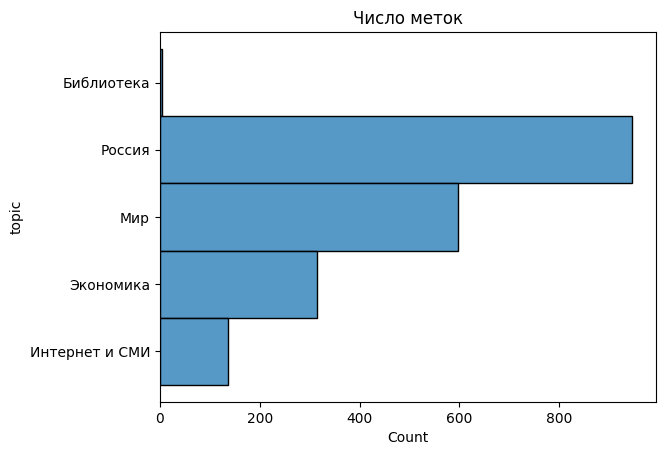

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
f1 = sns.histplot(y='topic', data=df1);
f1.set_title("Число меток")

In [ ]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels = ['Россия', 'Мир', 'Экономика', 'Интернет и СМИ']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17, rotation=45)
    ax.yaxis.set_ticklabels(labels, fontsize=17, rotation=0)
    ax.set_ylabel('Тест', fontsize=20)
    ax.set_xlabel('Предсказание', fontsize=20)
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df1, test_size=0.1, random_state=42)

print(f"Размер учебной выборки: {train_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")

Размер учебной выборки: (1800, 2)
Размер тестовой выборки: (200, 2)


In [ ]:
# Взял модель rubert-tiny
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

In [ ]:
token_lens = []

for txt in df1['text'].values:
    tokens = tokenizer.encode(txt, max_length=1024, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)
print(f"Максимальная длина токенизированной последовательности: {max_len}")

Максимальная длина токенизированной последовательности: 1024


In [ ]:
token_lens = []

for i,txt in enumerate(df1['text'].values):
    tokens = tokenizer.encode(txt, max_length=1024, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>800:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 15, TEXT: Сегодня утром в районах дагестанских селений Чабанмахи и Карамахи возобновились активные боевые действия подразделений внутренних войск МВД.  Как сообщили "Интерфаксу" во временном пресс-центре объединенной группировки Минобороны РФ в Дагестане, они встречают сильное огневое сопротивление со стороны экстремистов. Всего, по имеющимся в пресс-центре сведениям, группировка исламских боевиков в этом районе превышает 500 человек. Вчера в результате ожесточенного боя ими была выведена из строя боевая машина пехоты федеральных сил. Погибли двое и ранены еще двое военнослужащих. Вертолеты федеральных сил вчера нанесли 8 ракетных ударов по позициям боевиков в районах горы Чабан, а также в километре восточнее села Дуранги и в полутора километрах от того села. По боевым позициям исламистов также вела "сосредоточенный огонь" артиллерия.Удалось перехватить радиосообщений исламистов, в которых они просят о помощи у своих единомышленников в Чечне и Дагестане. 30 августа при продвижен

In [ ]:
df1['token_lens'] = token_lens

In [ ]:
df1.head()

,topic,text,token_lens
0,Библиотека,Бои у Сопоцкина и Друскеник закончились отступ...,289
1,Библиотека,"Министерство народного просвещения, в виду про...",103
2,Библиотека,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",674
3,Библиотека,Фотограф-корреспондент Daily Mirror рассказыва...,211
4,Библиотека,"Лица, приехавшие в Варшаву из Люблина, передаю...",268


In [ ]:
df1['topic'].value_counts()

,count
topic,
Россия,946
Мир,597
Экономика,315
Интернет и СМИ,137
Библиотека,5


In [ ]:
train_df['topic'] = train_df['topic'].map({'Россия':0,'Мир':1,'Экономика':2,'Интернет и СМИ':3,'Библиотека':4})

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1800 entries, 1872 to 1126
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   topic   1800 non-null   int64 
 1   text    1800 non-null   object
dtypes: int64(1), object(1)
memory usage: 42.2+ KB


In [ ]:
test_df['topic'] = test_df['topic'].map({'Россия':0,'Мир':1,'Экономика':2,'Интернет и СМИ':3,'Библиотека':4})

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1860 to 1551
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   topic   200 non-null    int64 
 1   text    200 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.7+ KB


In [ ]:
from torch.utils.data import DataLoader, Dataset

In [ ]:
# Преобразуем тексты в тензоры
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
train_dataset = TextDataset(train_df['text'].tolist(), train_df['topic'].tolist(), tokenizer)
test_dataset = TextDataset(test_df['text'].tolist(), test_df['topic'].tolist(), tokenizer)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
import torch.nn as nn
# Определяем модель для классификации
class BertClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
# Инициализируем модель
num_classes = 5  # Количество классов
model = BertClassifier(model, num_classes)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [ ]:
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct_predictions += torch.sum(preds == labels)

    return total_loss / len(data_loader), correct_predictions.double() / len(data_loader.dataset)


In [ ]:
# Оценка модели
def eval_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct_predictions += torch.sum(preds == labels)

    return total_loss / len(data_loader), correct_predictions.double() / len(data_loader.dataset)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
epochs = 5
for epoch in range(epochs):
    print(f"Эпоха {epoch + 1}/{epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Train loss: {train_loss}, Train accuracy: {train_acc}")

    val_loss, val_acc = eval_model(model, test_loader, criterion, device)
    print(f"Validation loss: {val_loss}, Validation accuracy: {val_acc}")

Эпоха 1/5
Train loss: 1.2817655738476104, Train accuracy: 0.4438888888888889
Validation loss: 1.0304085199649518, Validation accuracy: 0.55
Эпоха 2/5
Train loss: 0.869116547097147, Train accuracy: 0.6788888888888889
Validation loss: 0.6508330198434683, Validation accuracy: 0.76
Эпоха 3/5
Train loss: 0.6160333578565479, Train accuracy: 0.7755555555555556
Validation loss: 0.5256225283329303, Validation accuracy: 0.795
Эпоха 4/5
Train loss: 0.4894770642297458, Train accuracy: 0.8294444444444444
Validation loss: 0.47562806193645185, Validation accuracy: 0.81
Эпоха 5/5
Train loss: 0.41651367092818287, Train accuracy: 0.8511111111111112
Validation loss: 0.47829333406228286, Validation accuracy: 0.8


In [ ]:
def predict_test_dataset(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# Получаем предсказания для тестового датасета
predicted_labels, true_labels = predict_test_dataset(model, test_loader, device)

# Выводим первые несколько примеров
for i in range(min(10, len(test_df))):  # Показываем первые 10 примеров
    print(f"Текст: {test_df.iloc[i]['text']}")
    print(f"Истинный класс: {true_labels[i]}, Предсказанный класс: {predicted_labels[i]}")
    print()

Текст: Исследование, проведенное Reuters, показало, что подавляющее большинство американцев рассматривают "проблему-2000" как показатель чрезмерной зависимости американского общества от электроники. Такую точку зрения высказали 73,2 процента опрошенных. По результатам исследования Zogby International, респонденты в возрасте 65 лет и старше чуть болеше обеспокоены перспективами в связи с "проблемой-2000", чем более молодые граждане. В общей же сложности, 53 процента опрошенных заявили, что не интересуются "проблемой-2000". "Крайне обеспокоены" лишь 5,6 процента. Большинство респондентов сообщили также, что не слишком волнуются за уязвимость компьютерных систем в связи с наступлением 2000 года. За правительственные, военные, транспортные, медицинские или финансовые системы переживают менее 20 процентов опрошенных. Менее четверти опрошенных американцеви (22,5 процента) склонны считать, что правительство, средства массовой информации и представители компьютерной индустрии сильно переоценив

In [ ]:
# Пример предсказания
# Оцениваем точность модели на тестовом датасете
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Точность модели на тестовом датасете: {accuracy:.4f}")

Точность модели на тестовом датасете: 0.8000


In [ ]:
predicted_labels, true_labels = predict_test_dataset(model, test_loader, device)

# Выводим classification report
print(classification_report(
    true_labels,
    predicted_labels,
    target_names=['Россия', 'Мир', 'Экономика', 'Интернет и СМИ']
))

                precision    recall  f1-score   support

        Россия       0.87      0.90      0.88        98
           Мир       0.82      0.74      0.78        61
     Экономика       0.61      0.76      0.68        25
Интернет и СМИ       0.62      0.50      0.55        16

      accuracy                           0.80       200
     macro avg       0.73      0.72      0.72       200
  weighted avg       0.80      0.80      0.80       200



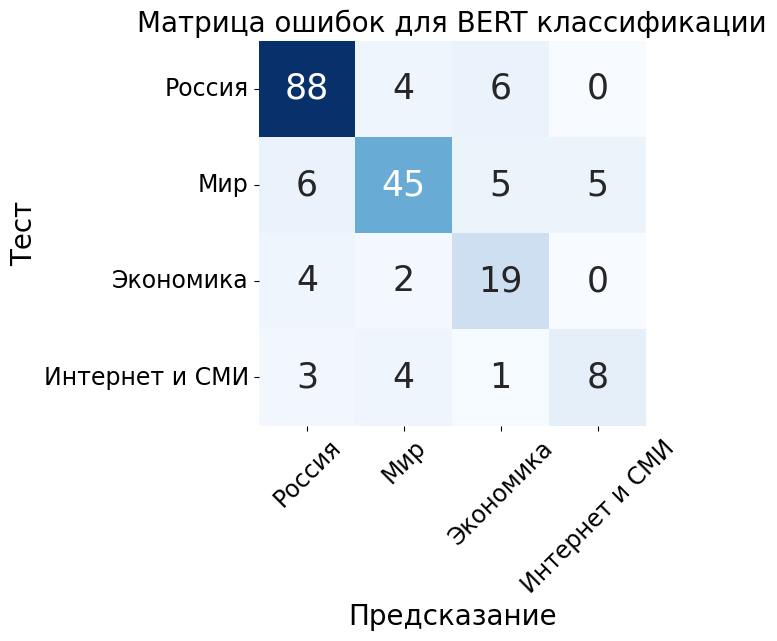

In [ ]:
conf_matrix(true_labels, predicted_labels, 'Матрица ошибок для BERT классификации')